In [1]:
import matplotlib.pyplot as plt
import os                               
import nibabel as nib
from PIL import Image
import numpy as np
import SimpleITK as sitk
import tqdm
import pandas as pd

In [6]:
def save_slice(slice, path, size):
    plt.figure()
    plt.imshow(slice, cmap='gray')
    plt.axis('off')
    plt.savefig(path, format='jpeg', bbox_inches='tight', pad_inches=0)
    plt.close()
    again = Image.open(path)
    im_resized = again.resize((size,size), Image.Resampling.LANCZOS)
    im_resized.save(path, 'jpeg')

In [3]:
# PROCESS ALL DATASET
# NOTE: Labels available for only 1295/1476 patients, so we will process only those
path = r"C:\Users\ances\Documents\Python\ETHZ\picai"
dataset_path = os.path.join(path, "data")
labels_path = os.path.join(path, "labels")
output_path = os.path.join(path, r"processed_data\full_dataset")

patients = os.listdir(labels_path) # work only with patients with labels
patients_data = [patient.split('_')[0] for patient in patients] # match with folder names in data

th1 = 750 # Area threshold for small->medium
th2 = 1500 # Area threshold for medium->large

#modalities = ['t2w', 'adc', 'hbv'] # problems with labels not matching for adc and hbv
modalities = ['t2w']
im_size = 512 # size of the output image

# Initialize dataframe 
df = pd.DataFrame(columns=['File_name', 'text'])

counter = 0 # counter for patients with tumor to monitor balancing of dataset

for i, patient in tqdm.tqdm(enumerate(patients), total=len(patients), desc='Processing data'):
    
    dir_patient_data = os.path.join(dataset_path, patients_data[i])
    dir_patient_labels = os.path.join(labels_path, patient)
    
    file_name = f"picai_{patients_data[i]}.jpeg"
    
    # First process the label
    # Load the .nii.gz file
    nii_data = nib.load(dir_patient_labels)
    img = nii_data.get_fdata() # convert to numpy array
    
    n_slices = img.shape[2]
    best = n_slices // 2 # default slice is the middle one
    area = 0
    if np.any(img): # if there are non-zero values i.e. there is a tumor
        counter += 1
        for k in range(n_slices):
            if np.count_nonzero(img[:, :, k]) > area:   # select the slice with the largest tumor area (can't use raw count see README)
                area = np.count_nonzero(img[:, :, k])
                best = k
                
    # Generate prompt
    if area > 0:
        if area >= th2:
            size = 'large'
        elif area > th1:
            size = 'medium'
        else:
            size = 'small'
        prompt = f'Prostate MRI t2, with {size} tumor'
    else:
        prompt = f'Prostate MRI t2, healthy'

    slice_label = img[:, :, best]
    #print(f'LABEL {i} SIZE: ', img.shape)
    output_dir_label = os.path.join(output_path+r'\seg', file_name)
    save_slice(slice_label, output_dir_label, im_size)
    
    # Update the dataframe
    df.loc[i] = [file_name, prompt]
    
    for modality in modalities:
        # Then process the data
        with os.scandir(dir_patient_data) as entries:
            for entry in entries:
                ## Unzip the compressed files
                if entry.is_file() and entry.name.endswith(rf'_{modality}.mha'):  # Check for _modality.mha files
                    file_path = entry.path
                    
                    image = sitk.ReadImage(file_path)

                    # Get the numpy array from the image
                    image_array = sitk.GetArrayFromImage(image)

                    slice_data = image_array[best, :, :]          # get the slice according to labels
                    #print(f'DATA {i} SIZE with MODALITY {modality} is: ', image_array.shape)
                    
                    # Save the processed data
                    output_dir_data = os.path.join(output_path+rf'\{modality}', file_name)   
                    save_slice(slice_data, output_dir_data, im_size)     


for modal in modalities:
    # Save the dataframe as csv
    df.to_csv(os.path.join(output_path+r'\t2w', 'metadata.csv'), index=False)

print(f'Dataset balancing: {counter} patients with tumor, {i+1-counter} patients without tumor. Total patients: {i+1}')

Processing data:   0%|          | 0/1295 [00:00<?, ?it/s]

Processing data: 100%|██████████| 1295/1295 [17:09<00:00,  1.26it/s]

Dataset balancing: 220 patients with tumor, 1075 patients without tumor. Total patients: 1295


In [7]:
import matplotlib.pyplot as plt
from PIL import Image

def interactive_selection(rows, sample_per_class, folder):
    """
    Iteratively display images and prompt so the user can select (y) or reject (n) them, (q) to quit.
    """
    counter = 0
    selected_rows = []
    for index, row in rows.iterrows():
        print(f'Selected: {counter}/{sample_per_class}')
        file_name = row['File_name']
        file_path = os.path.join(folder, file_name)
        
        if os.path.exists(file_path):
            img = Image.open(file_path)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(row['text'])
            plt.show()
            
            user_input = input("Keep this image? (y/n) (q to quit): ").strip().lower()
            clear_output(wait=True)
            
            if user_input == 'y':
                selected_rows.append(row)
                counter += 1
                if len(selected_rows) >= sample_per_class:
                    break
            elif user_input == 'q': #early quit
                raise KeyboardInterrupt
        else:
            print(f"Warning: {file_name} not found in the folder.")
    
    if counter < sample_per_class:
        print(f"Warning: Could not find {sample_per_class} images. Returning only {counter} images.")
        
    return pd.DataFrame(selected_rows)

In [ ]:
# CREATE A USABLE DATASET (original one is mostly healthy and too big)
import os
import shutil
import pandas as pd
from IPython.display import display, clear_output

full_path = r'C:\Users\ances\Documents\Python\ETHZ\picai\processed_data\full_dataset'  # Path to the full dataset
output_folder = r'C:\Users\ances\Documents\Python\ETHZ\picai\processed_data\selection100+100'  # Path to the new folder

t2w_folder = os.path.join(full_path, r't2w')
seg_folder = os.path.join(full_path, r'seg')
csv_path = os.path.join(t2w_folder, r'metadata.csv')  # Path to the CSV file

out_t2w = os.path.join(output_folder, r't2w')
out_seg = os.path.join(output_folder, r'seg')

df = pd.read_csv(csv_path)

sample_per_class = 100

# Filter rows containing 'tumor' and 'healthy'
tumor_rows = df[df['text'].str.contains('tumor', case=False, na=False)]
tumor_rows = tumor_rows.sample(frac=1, random_state=38).reset_index(drop=True)
healthy_rows = df[df['text'].str.contains('healthy', case=False, na=False)]
healthy_rows = healthy_rows.sample(frac=1, random_state=38).reset_index(drop=True)

# Interactive selection for tumor and healthy rows
# Needed because many images have problems (zoomed out, or 'displaced'), see full dataset for examples
selected_tumor_rows = interactive_selection(tumor_rows, sample_per_class, t2w_folder)
selected_healthy_rows = interactive_selection(healthy_rows, sample_per_class, t2w_folder)

# Concatenate the selected tumor and healthy rows and shuffle them
filtered_df = pd.concat([selected_tumor_rows, selected_healthy_rows])
filtered_df = filtered_df.sample(frac=1, random_state=38).reset_index(drop=True)

# Copy the selected files to the new folder
for file_name in filtered_df['File_name']:
    source_path_t2 = os.path.join(t2w_folder, file_name)
    source_path_seg = os.path.join(seg_folder, file_name)
    if os.path.exists(source_path_t2) and os.path.exists(source_path_seg):
        shutil.copy(source_path_t2, os.path.join(out_t2w, file_name))
        shutil.copy(source_path_seg, os.path.join(out_seg, file_name))
    else:
        print(f"Warning: {file_name} not found in the source folder.")

# Save the final CSV to the new t2 folder
out_csv = os.path.join(out_t2w, r'metadata.csv')
filtered_df.to_csv(out_csv, index=False)

Selected: 49/50


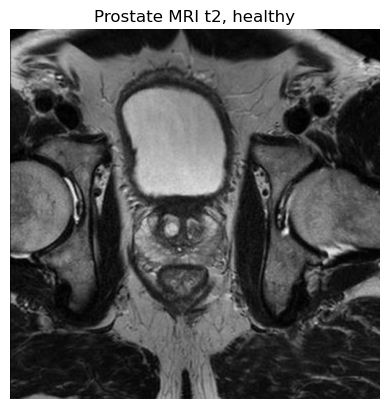

In [9]:
# CREATE THE TESTING DATASET
import os
import shutil
import pandas as pd
from IPython.display import display, clear_output

full_path = r'C:\Users\ances\Documents\Python\ETHZ\picai\processed_data\full_dataset'  # Path to the full dataset
training_path = r'C:\Users\ances\Documents\Python\ETHZ\picai\processed_data\selection100+100'  # Path to the training set
output_folder = r'C:\Users\ances\Documents\Python\ETHZ\picai\processed_data\selection100+100\testset'  # Path to the new folder (testing set)

t2w_folder = os.path.join(full_path, r't2w')
seg_folder = os.path.join(full_path, r'seg')
csv_path = os.path.join(t2w_folder, r'metadata.csv')  # Path to the full CSV file

t2w_folder_training = os.path.join(training_path, r't2w')
seg_folder_training = os.path.join(training_path, r'seg')
csv_path_training = os.path.join(t2w_folder_training, r'metadata.csv')  # Path to the training CSV file

out_t2w = os.path.join(output_folder, r't2w')
out_seg = os.path.join(output_folder, r'seg')

df = pd.read_csv(csv_path)
df_training = pd.read_csv(csv_path_training)

sample_per_class = 50

# Filter rows containing 'tumor' and 'healthy'
tumor_rows = df[df['text'].str.contains('tumor', case=False, na=False)]
tumor_rows = tumor_rows.sample(frac=1, random_state=38).reset_index(drop=True)
healthy_rows = df[df['text'].str.contains('healthy', case=False, na=False)]
healthy_rows = healthy_rows.sample(frac=1, random_state=38).reset_index(drop=True)

tumor_rows_training = df_training[df_training['text'].str.contains('tumor', case=False, na=False)] # check if there are already some in the training set
healthy_rows_training = df_training[df_training['text'].str.contains('healthy', case=False, na=False)] # same

# eliminate the rows that are already in the training set to avoid leakage!
tumor_rows = tumor_rows[~tumor_rows['File_name'].isin(tumor_rows_training['File_name'])]
healthy_rows = healthy_rows[~healthy_rows['File_name'].isin(healthy_rows_training['File_name'])]

# Interactive selection for tumor and healthy rows
# Needed because many images have problems (zoomed out, or 'displaced')
selected_tumor_rows = interactive_selection(tumor_rows, sample_per_class, t2w_folder)
selected_healthy_rows = interactive_selection(healthy_rows, sample_per_class, t2w_folder)

# Concatenate the selected tumor and healthy rows and shuffle them
filtered_df = pd.concat([selected_tumor_rows, selected_healthy_rows])
filtered_df = filtered_df.sample(frac=1, random_state=38).reset_index(drop=True)

# Copy the selected files to the new folder
for file_name in filtered_df['File_name']:
    source_path_t2 = os.path.join(t2w_folder, file_name)
    source_path_seg = os.path.join(seg_folder, file_name)
    if os.path.exists(source_path_t2) and os.path.exists(source_path_seg):
        shutil.copy(source_path_t2, os.path.join(out_t2w, file_name))
        shutil.copy(source_path_seg, os.path.join(out_seg, file_name))
    else:
        print(f"Warning: {file_name} not found in the source folder.")

# Save the final CSV to the new t2 folder
out_csv = os.path.join(out_t2w, r'metadata.csv')
filtered_df.to_csv(out_csv, index=False)

In [10]:
# Due to not having enough tumor samples in the testing set, we need to remove some healthy samples from the test until we have a balanced dataset
import os
import pandas as pd

output_folder = r'C:\Users\ances\Documents\Python\ETHZ\picai\processed_data\selection100+100\testset'  # Path to the testing set

out_t2w = os.path.join(output_folder, r't2w')
out_seg = os.path.join(output_folder, r'seg')
csv_path = os.path.join(output_folder, r't2w\metadata.csv')

df = pd.read_csv(csv_path)

# Filter rows containing 'tumor' and 'healthy'
tumor_rows = df[df['text'].str.contains('tumor', case=False, na=False)]
healthy_rows = df[df['text'].str.contains('healthy', case=False, na=False)]

# Count the number of tumor and healthy rows
n_tumor = len(tumor_rows)
n_healthy = len(healthy_rows)
# and now select healthy rows at random to match the number of tumor rows
selected_healthy_rows = healthy_rows.sample(n=n_tumor, random_state=38) # assuming n_tumor < n_healthy

# Concatenate the selected tumor and healthy rows and shuffle them
filtered_df = pd.concat([tumor_rows, selected_healthy_rows])
filtered_df = filtered_df.sample(frac=1, random_state=38).reset_index(drop=True)

# eliminate the files from the folders if not present in the csv
for file_name in os.listdir(out_t2w):
    if file_name == 'metadata.csv': # no metadata in the seg folder
        continue
    if file_name not in filtered_df['File_name'].values:
        os.remove(os.path.join(out_t2w, file_name))
        os.remove(os.path.join(out_seg, file_name))

# Save the final CSV to the new t2 folder
out_csv = os.path.join(out_t2w, r'metadata.csv')
filtered_df.to_csv(out_csv, index=False)

Below just some useful code to inspect the data

In [ ]:
# display interactively using the next cell
i = 19
dir_patient_data = os.path.join(dataset_path, patients_data[i])
dir_patient_labels = os.path.join(labels_path, patients[i])

nii_data = nib.load(dir_patient_labels)
img = nii_data.get_fdata() # convert to numpy array

n_slices = img.shape[2]
best = n_slices // 2 # default slice is the middle one
area = 0
if np.any(img): # if there are non-zero values i.e. there is a tumor
    counter += 1
    for k in range(n_slices):
        if np.count_nonzero(img[:, :, k]) > area:   # select the slice with the largest tumor area (can't use raw count see README)
            area = np.count_nonzero(img[:, :, k])
            best = k
            
# Generate prompt
if area > 0:
    if area >= th2:
        size = 'large'
    elif area > th1:
        size = 'medium'
    else:
        size = 'small'
    prompt = f'Prostate MRI t2, with {size} tumor'
else:
    prompt = f'Prostate MRI t2, healthy'

slice_label = img[:, :, best]

# Then process the data
with os.scandir(dir_patient_data) as entries:
    for entry in entries:
        ## Unzip the compressed files
        if entry.is_file() and entry.name.endswith('_t2w.mha'):  # Check for _t2w.mha files
            file_path = entry.path
            
            image = sitk.ReadImage(file_path)

            # Get the numpy array from the image
            image_array = sitk.GetArrayFromImage(image)

            slice_data = image_array[best, :, :]          # get the slice according to labels

plt.figure()
plt.imshow(slice_label, cmap='gray')
plt.axis('off')
plt.figure()
plt.imshow(slice_data, cmap='gray')

import ipywidgets as widgets
from IPython.display import display

def plot_slices(slice_index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_array[slice_index, :, :], cmap='gray')
    plt.imshow(np.ma.masked_where(img[:, :, slice_index] == 0, img[:, :, slice_index]), cmap='viridis', alpha=0.5)
    plt.title(f'Slice {slice_index} - Overlay')
    plt.axis('off')
    
    plt.show()

slice_slider = widgets.IntSlider(min=0, max=img.shape[2]-1, step=1, value=best)
widgets.interact(plot_slices, slice_index=slice_slider)